This notebook has all the code required to emulate the results from a simulation of tumour growth shown in - 
Williams, M. J., Werner, B., Barnes, C. P., Graham, T. A., & Sottoriva, A. (2016). Identification of neutral tumor evolution across cancer types. Nature Genetics. http://doi.org/10.1038/ng.3489

Notebook is laid out as follows, the first cell includes code to include the required packages, and the module NeutralEvolution that defines all types and functions used in the notebook. The following sections each have headings and short descriptions of the results generated and produces equivalent figures to those seen in the publication. In the publication, outputs from the simulations were saved and figures generated in R(v3), in this notebook we used the Gadfly package to produce inline plots.

In [1]:
#push current path where NeutralEvolution.jl is saved onto LOAD_PATH variable
#NeutralEvolution module contains all code required to generate plots as seen in paper

push!(LOAD_PATH,pwd())
using NeutralEvolution

#Call required packages
using Distributions
using Gadfly
using DataFrames
using GLM
using PyCall
using Colors

# Stochastic simulation of tumour growth

Below is taken from the paper and explains the methodology of the simulation.

To further validate our analytical model and to test the robustness to the noise in NGS data, we developed a stochastic simulation of tumor growth and accumulation of mutations that allowed us to generate synthetic datasets. The model was written and analysed in the Julia programming language.  We then applied the analytical model to the simulated data to confirm that sources of noise in NGS data do not considerably impact our results. In particular, we verified that we can reliably extract input parameters of the simulation (namely the mutation rate) from “noisy” synthetic data. Confounding factors in the data include normal contamination, sampling effects, the detection limit of NGS mutation calling, and variable read depth. We simulate a tumor using a branching process with discrete generations, beginning with a single “transformed” cancer cell that gives rise to the malignancy. Under exponential growth, the population at time t will be given by:

\begin{equation}
N(t)=R^t=e^{ln(R)t}
\end{equation}

Where R is the average number of offspring per cell and the time t is in units of generations. We will consider primarily the case when R=2 (a cell always divides into 2), but we will also consider values <2, noting that R must be greater than 1 to have growth. At each division, cells acquire new mutations at a rate μ and we assume every new mutation is unique (infinite sites approximation). The number of mutations acquired by a newborn cell at division is a random number drawn from a Poisson distribution. Each cell in the population is defined by its mutations and its ancestral history (by recording it’s parent cell). Using this information we can then reconstruct the history of the whole tumor and crucially, calculate the variant allele frequency of all mutations in the population. To relate the discrete simulation to the continuous analytical model we will now re-derive equation [7] within the context of our model. As we simulate a growing tumor using discrete generations, both the mutation rate μ and per capita growth rate $\lambda=ln(R)$ are in units of generations. For an offspring probability distribution $P=(p_0,p_1,p_2)$ where $p_k$=P(# of OFFSPRING = k), the average number of offspring R is simply given by the expected value of P:

\begin{equation}
R=E[P]=p_1+2p_2
\end{equation}

For example, for R=2 we have P=($p_0$=0,$p_1$=0,$p_2$=1). By choosing different offspring probability distributions we can easily modulate the growth rate. We note that we are now expressing both μ and λ as rates per generation rather than probabilities (all rates are scaled by units of generation). This allows us to write the growth function as $N(t)=e^{\lambda t}$ with $\lambda=ln(R)$. Proceeding as in the main text, our cumulative number of mutations with an allelic frequency f is therefore:

\begin{equation}
M(f)=\frac{\mu}{\lambda} \left (\frac{1}{f}-\frac{1}{f_{max} }\right)
\end{equation}

Therefore, when fitting the model to our stochastic simulation we extract $\frac{\mu}{\lambda}$ from the linear fit, making it straightforward to compare the simulation with the analytical model.
NGS data only captures a small fraction of the variability in a tumor, as the resolution is often limited to alleles with frequency >10% due to sequencing depth and limitations in mutation calling. To account for this, we employ a multistage sampling scheme in our simulations. For all simulations reported here we grow the tumor to size 1024 cells, which gives a minimum allele frequency of ~0.1%, considerably smaller than the 10% attainable in next generation sequencing data. After growing the tumor and calculating the VAF for all alleles, we take a sample of the alleles in the population, noting that we are assuming the population is well mixed and has no spatial structure. We can vary the percentage of alleles we sample, thus allowing us to investigate the effect of the depth of sequencing on our results.  As we know the true allelic frequency in the simulated population, we can use the multinomial distribution to produce a sample of the “sequenced” alleles, where the probability of sampling allele i is proportional to its frequency. The probability mass function is given by:

\begin{equation}
f(x;n,p)=\frac{n!}{(x_1 !…x_k !)} \prod _{i=1}^{k}p_i^{x_i}    \quad ;\quad x_1+⋯x_k=n
\end{equation}

where $x_i$ is the sampled frequency of allele $i$, $n$ is the number of trials (the chosen percentage of alleles sampled) and $p_i$ is the probability of sampling allele i  (which has frequency $\rho_i$ in the original population):

\begin{equation}
p_i=\frac{\rho_i}{\sum_{j=1}^{k} \rho_j }
\end{equation}

The variant allele frequency VAF is therefore given by:

\begin{equation}
VAF=\frac{x_i}{N_i}
\end{equation}

Where $N_i$ is the total number of sampled cells from which every sampled allele is derived. As we are assuming a constant mutation rate $\mu$, we can assume that the percentage of alleles sampled comes from an equivalent percentage of cells. However, to include an additional element of noise that resembles the variability of read depth, we calculate a new $N_i$  for each allele $i$, which approximates the read depth.   For a desired “sequencing” depth D we calculate the corresponding percentage of the population we need to sample that will give us our desired depth. For example, for a desired depth of 100X from a population of 1000 cells, we would need to sample 10% of the population. To include some variability in depth across all alleles we use Binomial sampling so that $N_i$ is a distribution with mean D. 
Contamination from non-tumor cells in NGS results in variant allele frequencies being underestimated. To include this effect in our simulation we can modify our N_i by an additional fraction ε – the percentage of normal contamination. Our VAF calculation thus becomes:
\begin{equation}
VAF=\frac{x_i}{N_i (1+\epsilon)}
\end{equation}
We also include detection limit in our sampling scheme, we only include alleles that have an allelic frequency greater than a specified limit in the original tumor population.


# Stochastic simulation converges to analytical solution

Here we show that our stochastic simulations can recapitulate NGS data nicely and that the stochastic simulation converges to our analytical result:

\begin{equation}
M(f)=\frac{\mu}{\lambda} \left (\frac{1}{f}-\frac{1}{f_{max} }\right)
\end{equation}

For all simulation considered here we consider an ideal branching process where all cells divide into 2 at each generation.

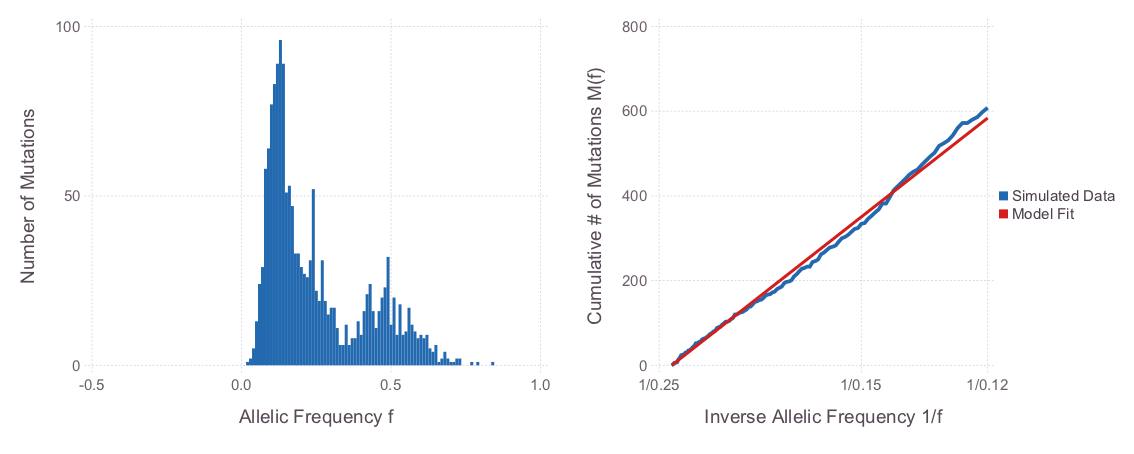

5.956156 seconds (7.95 M allocations: 365.055 MB, 2.24% gc time)
mu is 97.12435025607641,r2 is 0.9978264493917737


In [2]:
set_default_plot_size(30cm, 12cm)
#amount of normal contamination
norm_cont=0.0

#set limits of cumulative sum
min_range=0.12
max_range=0.24

#this is mutation rate per cell division, our model is in term of mutation rate per genome, 
#so for diploid genome divide by 2
mut_rate=200

#set number of clonal mutations, this is a multiplicative factor of the mutation rate
clon_peak=2

#set detection limit
det_limit=0.1

#set ploidy of genome
ploidy=2

#set target read depth
read_depth=100

@time DF,DF1,coefs,r2=idealsampling(12,mut_rate,clon_peak,norm_cont,min_range,max_range,det_limit,ploidy,read_depth);
println("mu is $(coefs[1]),r2 is $(r2)")
p1=plot(DF,x="VAF",y="freq",Geom.bar,Guide.xlabel("Allelic Frequency f"),Guide.ylabel("Number of Mutations"),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
default_color=colormap("blues")[80],bar_spacing=0.00001cm))

p2=plot(DF1,layer(x="invVAF",y="prediction",Geom.line,Theme(default_color=default_color=colormap("reds")[80],line_width=0.08cm)),
layer(x="invVAF",y="cumsum",Geom.line,Theme(line_width=0.1cm,default_color=colormap("blues")[80])),
Scale.x_continuous(minvalue=minimum(DF1[:invVAF]), maxvalue=maximum(DF1[:invVAF]),labels=func),
Scale.y_continuous(minvalue=0, maxvalue=maximum(DF1[:cumsum])),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm),
Guide.manual_color_key("", ["Simulated Data", "Model Fit"], [color(colormap("blues")[80]), color(colormap("reds")[80])]),
Guide.xlabel("Inverse Allelic Frequency 1/f"),Guide.ylabel("Cumulative # of Mutations M(f)"),
Guide.xticks(ticks=[1/0.25-1/max_range,1/0.15-1/max_range,1/min_range-1/max_range]))

hstack(p1,p2)

In [3]:
#enter directory for plots and data here
data_dir="data"
plots_dir="plots"
today = readall(`date +'%d.%m.%Y'`)[1:10]
sname="1_simulation"
writetable("$(data_dir)/$(today).$(sname)_processed.csv",DF1)
writetable("$(data_dir)/$(today).$(sname)_raw.csv",DF)
draw(PDF("$(plots_dir)/$(today).$(sname)_hist.pdf", 12cm, 12cm), p1)
draw(PDF("$(plots_dir)/$(today).$(sname)_cumsum.pdf", 16cm, 12cm), p2)

# Fit Distribution

Here we confirm that over a large number of simulations we can accurately recover the mutation rate from the model fit. The slight overestimation is likely due to some of the elements of noise introduced we bias our results.

In [4]:
norm_cont=0.0
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=2
det_limit=0.1
ploidy=2

#num samples is the number of times we run the same simulation, for the results of the paper we used 10,000
num_samples=100
numgen=11
read_depth=100

@time statvec,mu,rsq=multsample(numgen,num_samples,mut_rate,clon_peak,norm_cont,min_range,max_range,det_limit,ploidy,read_depth)
DF = DataFrame(mu=mu,rsq=rsq);

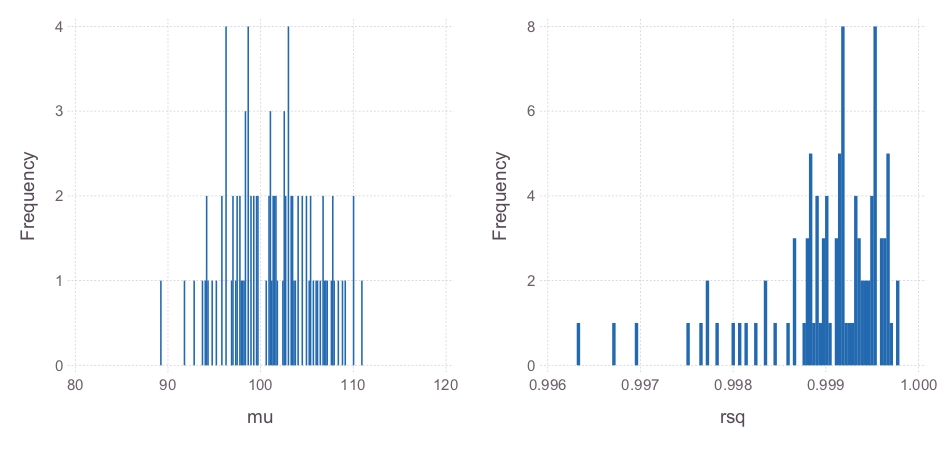

6.997677 seconds (61.41 M allocations: 3.326 GB, 7.97% gc time)


In [5]:
set_default_plot_size(25cm, 12cm)
p1=plot(DF,x="mu",Geom.histogram,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=colormap("blues")[80]),
Guide.xlabel("mu"),Guide.ylabel("Frequency"),Scale.x_continuous(minvalue=80, maxvalue=120))

p2=plot(DF,x="rsq",Geom.histogram,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=colormap("blues")[80]),
Guide.xlabel("rsq"),Guide.ylabel("Frequency"))

hstack(p1,p2)

In [6]:
mean(DataArray(DF),1) #mean mutation rate and R^2 values

1x2 DataArrays.DataArray{Float64,2}:
 101.238  0.999012

In [7]:
sname="mutation_estimates_dist"
writetable("$(data_dir)/$(today).$(sname).csv",DF)
draw(PDF("$(plots_dir)/$(today).$(sname)_mu.pdf", 15cm, 12cm), p1)
draw(PDF("$(plots_dir)/$(today).$(sname)_rsq.pdf", 15cm, 12cm), p2)

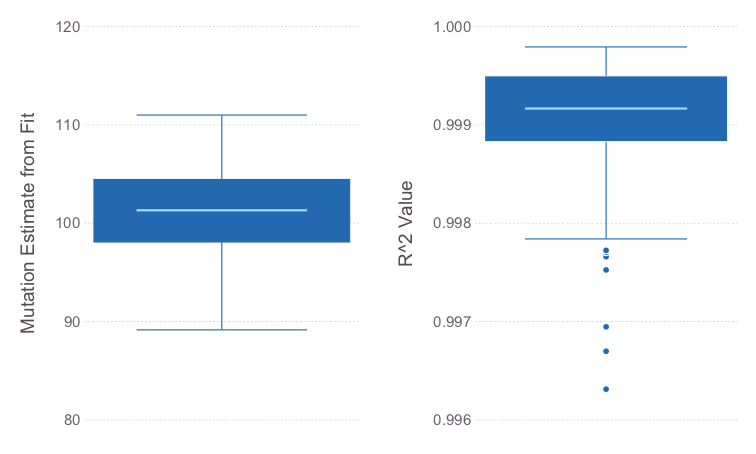

In [8]:
set_default_plot_size(20cm, 12cm)
p1=plot(DF,y="mu",Geom.boxplot,Stat.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("blues")[80],boxplot_spacing=0.5cm),
Guide.xlabel(""),Guide.ylabel("Mutation Estimate from Fit"))
p2=plot(DF,y="rsq",Geom.boxplot,Stat.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("blues")[80],boxplot_spacing=0.5cm),
Guide.xlabel(""),Guide.ylabel("R^2 Value"))
p=hstack(p1,p2)

In [9]:
draw(PDF("$(plots_dir)/$(today).mut_dist_boxplot.pdf", 15cm, 12cm), p)

# Clonal Peak

Here we confirm the robustness to the number of clonal mutations.

In [10]:
norm_cont=0.0
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=[0,2,4]
det_limit=0.1
ploidy=2
numgen=11
stats = zeros(Float64,3,2)
DFmu = DataFrame()
DFrsq = DataFrame()
j=1
mu_array=Array{Float64,0}
read_depth=100

@time for i in clon_peak
    stats[j,:],DFmu[symbol("$(round(Int64,(mut_rate/2) * i))")],DFrsq[symbol("$(round(Int64,(mut_rate/2) * i))")] = 
    multsample(numgen,num_samples,mut_rate,i,norm_cont,min_range,max_range,
    det_limit,ploidy,read_depth)
    j+=1
end

 19

In [11]:
stats

3x2 Array{Float64,2}:
 101.387  0.999062
 101.395  0.999002
 100.475  0.999027

.683225 seconds (184.19 M allocations: 10.018 GB, 8.80% gc time)


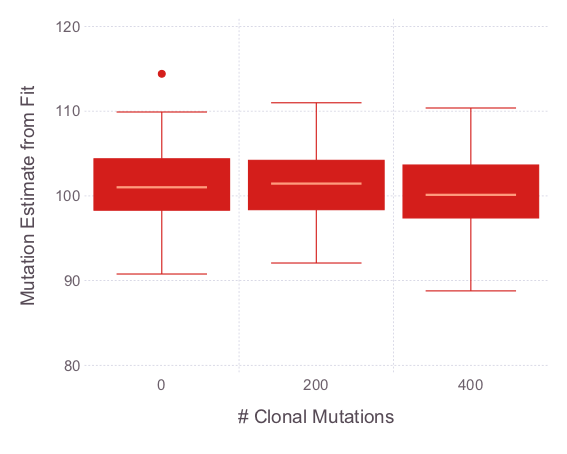

In [12]:
set_default_plot_size(15cm, 12cm)
p=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("# Clonal Mutations"),Guide.ylabel("Mutation Estimate from Fit"))

In [13]:
sname="clonalpeakmu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p)

sname="clonalpeakrsq"
writetable("$(plots_dir)/$(today).$(sname).csv",DFrsq)


# Normal Contamination

Here we confirm the robustness to the amount of normal contamination.

In [14]:
norm_cont=[0.0,0.1,0.2,0.3,0.4,0.5]
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=1
det_limit=0.1
ploidy=2
read_depth=100
#num_samples=100
numgen=11
stats = zeros(Float64,6,2)
DFmu = DataFrame()
DFrsq = DataFrame()
j=1
mu_array=Array{Float64,0}
for i in norm_cont
    stats[j,:],DFmu[symbol("$(Int64(i*100)) %")],DFrsq[symbol("$(Int64(i*100)) %")] = 
    multsample(numgen,num_samples,mut_rate,clon_peak,i,min_range,max_range,
    det_limit,ploidy,read_depth)
    j+=1
end

In [15]:
stats

6x2 Array{Float64,2}:
 100.388   0.999078
  95.8391  0.997203
  88.6436  0.996725
  76.5265  0.997607
  59.1341  0.988086
  47.5028  0.992537

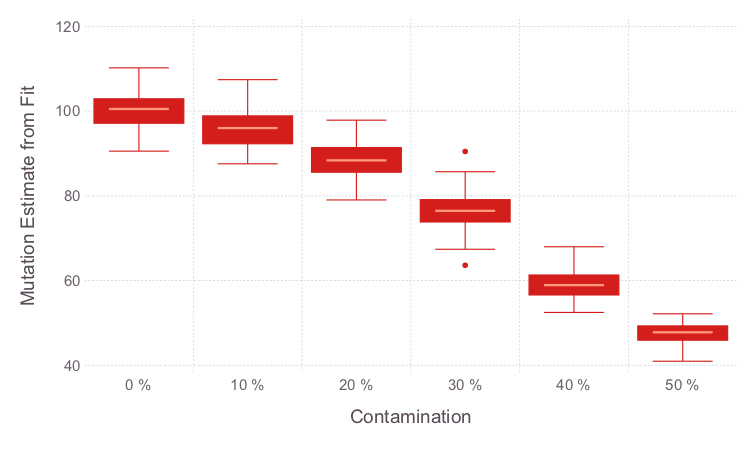

In [16]:
set_default_plot_size(20cm, 12cm)
p=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Contamination"),Guide.ylabel("Mutation Estimate from Fit"))

In [17]:
sname="contaminationmu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p)
draw(SVG("$(plots_dir)/$(today).$(sname).svg", 15cm, 12cm), p)
sname="contaminationrsq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)


In [18]:
#corrected contamination
DFmu[2] = DFmu[2].*(1+0.1);
DFmu[3] = DFmu[3].*(1+0.2);
DFmu[4] = DFmu[4].*(1+0.3);
DFmu[5] = DFmu[5].*(1+0.4);
DFmu[6] = DFmu[6].*(1+0.5);

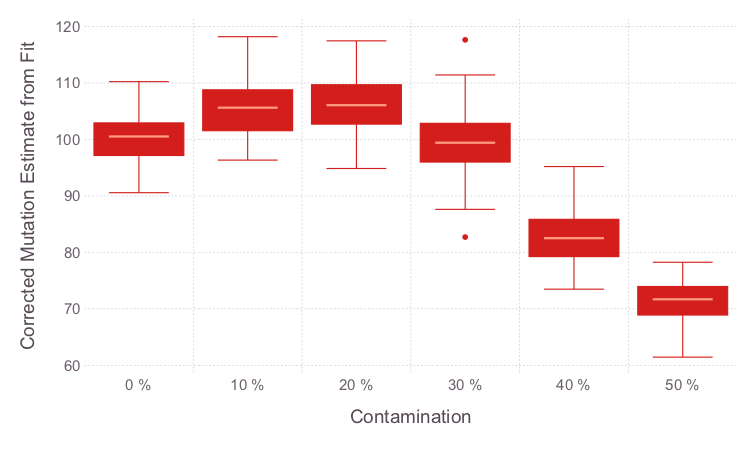

In [19]:
set_default_plot_size(20cm, 12cm)
p=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Contamination"),Guide.ylabel("Corrected Mutation Estimate from Fit"))

In [20]:
sname="correctedcontaminationmu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p)
draw(SVG("$(plots_dir)/$(today).$(sname).svg", 15cm, 12cm), p)
sname="correctedcontaminationrsq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)

# Detection Limit

In [21]:
norm_cont=0.0
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=1
det_limit=[0.01,0.05,0.1]
ploidy=2
read_depth=100
#num_samples=100
numgen=11
stats = zeros(Float64,3,2)
DFmu = DataFrame()
DFrsq = DataFrame()
j=1
mu_array=Array{Float64,0}
for i in det_limit
    stats[j,:],DFmu[symbol("$(round(Int64,i*100)) %")],DFrsq[symbol("$(round(Int64,i*100)) %")] = 
    multsample(numgen,num_samples,mut_rate,clon_peak,norm_cont,min_range,max_range,
    i,ploidy,read_depth)
    j+=1
end

In [22]:
stats

3x2 Array{Float64,2}:
 104.73   0.998712
 103.767  0.998762
 101.261  0.998996

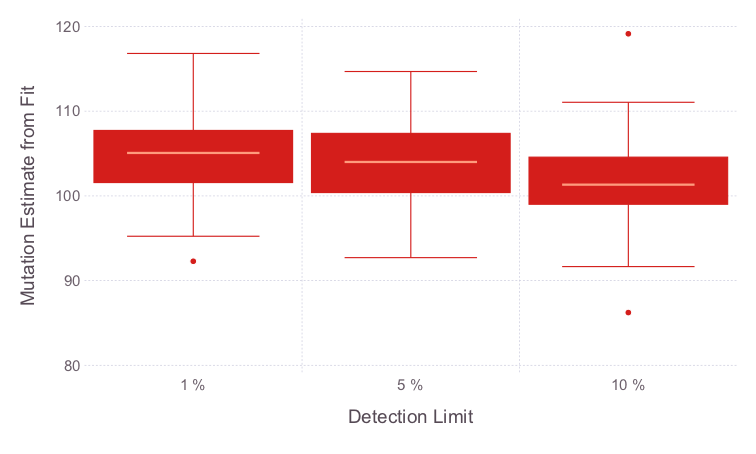

In [23]:
set_default_plot_size(20cm, 12cm)
p=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Detection Limit"),Guide.ylabel("Mutation Estimate from Fit"))

In [24]:
sname="detection_limitmu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p)
draw(SVG("$(plots_dir)/$(today).$(sname).svg", 15cm, 12cm), p)
sname="detection_limitrsq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)

# Read Depth

In [25]:
norm_cont=0.0
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=1
det_limit=0.1
ploidy=2
read_depth=[25,50,75,100]
#num_samples=100
numgen=11
stats = zeros(Float64,4,2)
DFmu = DataFrame()
DFrsq = DataFrame()
j=1
mu_array=Array{Float64,0}
for i in read_depth
    stats[j,:],DFmu[symbol("$(Int64(i)) ")],DFrsq[symbol("$(Int64(i))")] = multsample(numgen,num_samples,mut_rate,clon_peak,norm_cont,min_range,max_range,
    det_limit,ploidy,i)
    j+=1
    println("finished $(i)")
end

finished 25
finished 50
finished 75
finished 100


In [26]:
stats

4x2 Array{Float64,2}:
  88.6192  0.993902
 100.007   0.997013
 101.757   0.99854 
 101.763   0.999104

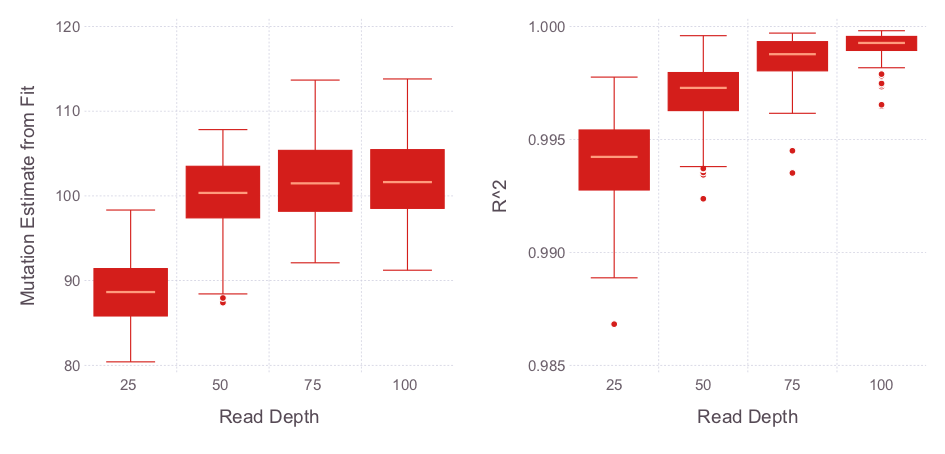

In [27]:
set_default_plot_size(25cm, 12cm)
p1=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Read Depth"),Guide.ylabel("Mutation Estimate from Fit"))
p2=plot(stack(DFrsq),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Read Depth"),Guide.ylabel("R^2"))

hstack(p1,p2)

In [28]:
sname="read_depthmu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p1)

sname="read_depthrsq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)
draw(PDF("$(plots_dir)/$(today).$(sname).pdf", 15cm, 12cm), p2)


# Mutation Rate

In [29]:
norm_cont=0.0
min_range=0.12
max_range=0.24
mut_rate=[5,20,200]
clon_peak=1
det_limit=0.1
ploidy=2
read_depth=100
#num_samples=100
numgen=11
stats = zeros(Float64,3,2)
DFmu = DataFrame()
DFrsq = DataFrame()
j=1
mu_array=Array{Float64,0}
for i in mut_rate
    println(i)
    stats[j,:],DFmu[symbol("$(Int64(i))")],DFrsq[symbol("$(Int64(i))")] = multsample(numgen,num_samples,i,clon_peak,norm_cont,min_range,max_range,
    det_limit,ploidy,read_depth)
    j+=1
end

5
20
200


In [30]:
#remember due to ploidy mutation rate is half on input
stats

3x2 Array{Float64,2}:
   2.49629  0.967522
  10.0833   0.99214 
 100.806    0.999053

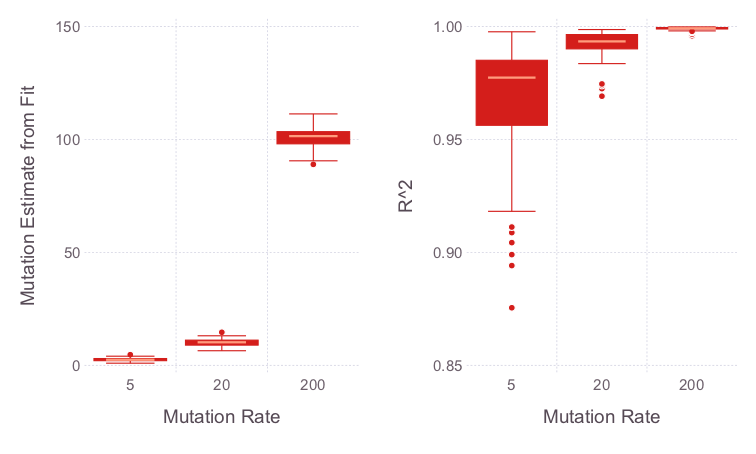

In [31]:
set_default_plot_size(20cm, 12cm)
p1=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Mutation Rate"),Guide.ylabel("Mutation Estimate from Fit"))
p2=plot(stack(DFrsq),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Mutation Rate"),Guide.ylabel("R^2"))
hstack(p1,p2)

In [32]:
sname="mut_ratemu"
writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(data_dir)/$(today).$(sname).pdf", 15cm, 12cm), p1)

sname="mut_ratersq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)
draw(PDF("$(data_dir)/$(today).$(sname).pdf", 15cm, 12cm), p2)


# Different Growth rates

Here we demonstrate that we still recover the mutation rate and neutrality under different growth regimes, but that the variance in the mutation rate estimates ($\mu$) is more variable and that we would missclassify a higher proportion of tumours as non - nuetral due to poorer $R^2$ values.

In [33]:
probmat=[[0.0,0.0,1] [0.05,0.1,0.85] [0.1,0.2,0.7] [0.2,0.2,0.6] [0.2,0.4,0.4]]
norm_cont=0
min_range=0.12
max_range=0.24
mut_rate=200
clon_peak=1
det_limit=0.1
read_depth=100
DFmu=DataFrame()
DFrsq=DataFrame()

for j = 1:length(probmat[1,:])
    
    println(j)
    lambda = log(probmat[2,j]+2*probmat[3,j])
    mu=zeros(Float64,num_samples)
    rsq=zeros(Float64,num_samples)
    p=prob(probmat[:,j],probmat[:,j])
    
    for i = 1:num_samples
        DF1,DF2,x,r=fullmodel_sampling(1000,mut_rate,clon_peak,norm_cont,min_range,max_range,p,lambda,det_limit,read_depth);
        mu[i]=x[1]
        rsq[i] =r
    end
    
    DFmu[symbol("ln($(round(probmat[2,j]+2*probmat[3,j],3)))")]=mu
    DFrsq[symbol("ln($(round(probmat[2,j]+2*probmat[3,j],3)))")]=rsq
end

1
2
3
4
5


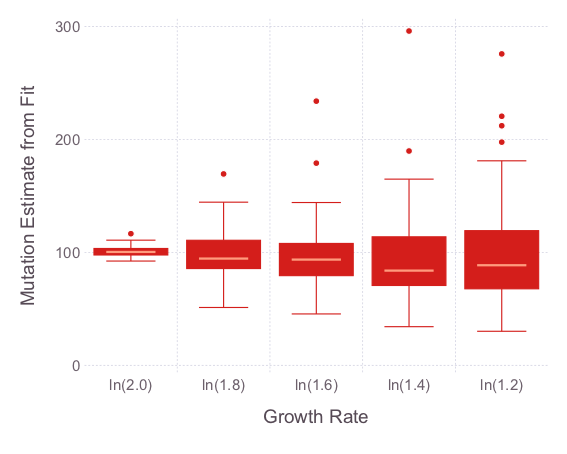

In [34]:
set_default_plot_size(15cm, 12cm)
p1=plot(stack(DFmu),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Growth Rate"),Guide.ylabel("Mutation Estimate from Fit"))

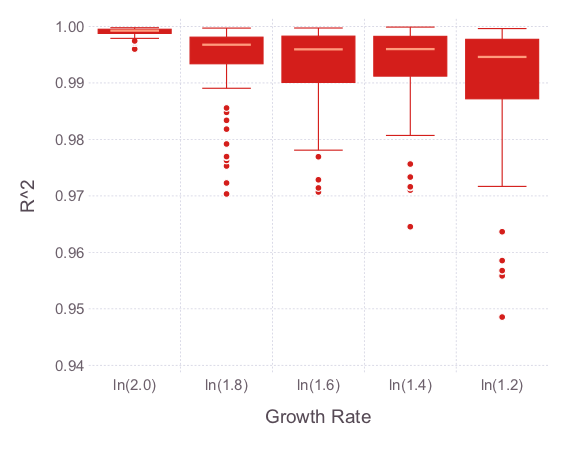

In [35]:
set_default_plot_size(15cm, 12cm)
p3=plot(stack(DFrsq),x="variable",y="value",Geom.boxplot,
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm,default_color=default_color=colormap("reds")[80],boxplot_spacing=0.5cm),
Guide.xlabel("Growth Rate"),Guide.ylabel("R^2"))

In [36]:
sname="different.lambda_mu"

writetable("$(data_dir)/$(today).$(sname).csv",DFmu)
draw(PDF("$(data_dir)/$(today).$(sname).pdf", 15cm, 12cm), p1)


sname="different.lambda_rsq"
writetable("$(data_dir)/$(today).$(sname).csv",DFrsq)
draw(PDF("$(data_dir)/$(today).$(sname).pdf", 15cm, 12cm), p1)

# Mixing Clones

Now we consider the case of 2 mixed clones which may arise as described in the online methods of the paper.

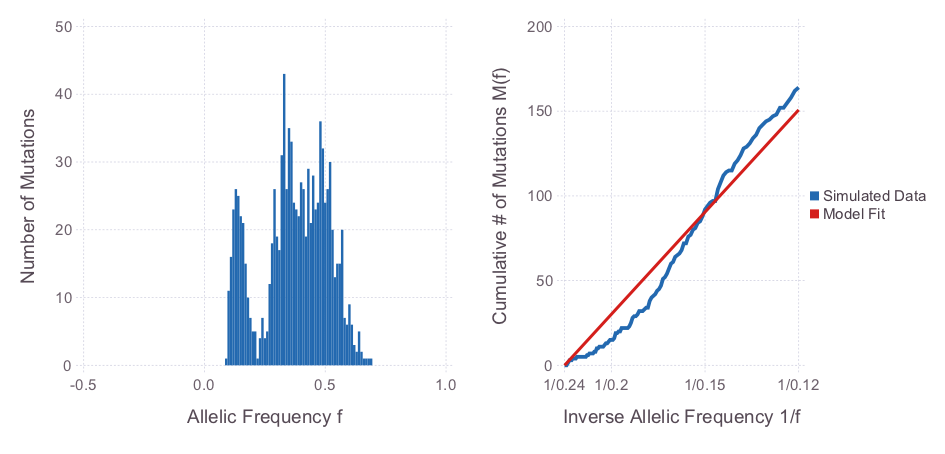

In [37]:
set_default_plot_size(25cm, 12cm)
@time DFhist,DFfit,coefficient,rsq,tV=mixing(1000,0.7,0.3,100)
p1=plot(DFhist,x="VAF",y="freq",Geom.bar,Guide.xlabel("Allelic Frequency f"),Guide.ylabel("Number of Mutations"),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
default_color=colormap("blues")[80],bar_spacing=0.00001cm))
p2=plot(DFfit,layer(x="invVAF",y="prediction",Geom.line,Theme(default_color=default_color=colormap("reds")[80],line_width=0.08cm)),
layer(x="invVAF",y="cumsum",Geom.line,Theme(line_width=0.1cm,default_color=colormap("blues")[80])),
Scale.x_continuous(minvalue=minimum(DFfit[:invVAF]), maxvalue=maximum(DFfit[:invVAF]),labels=func),
Scale.y_continuous(minvalue=0, maxvalue=maximum(DFfit[:cumsum])),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm),
Guide.manual_color_key("", ["Simulated Data", "Model Fit"], [color(colormap("blues")[80]), color(colormap("reds")[80])]),
Guide.xlabel("Inverse Allelic Frequency 1/f"),Guide.ylabel("Cumulative # of Mutations M(f)"),
Guide.xticks(ticks=[1/(max_range)-1/max_range,1/0.2-1/max_range,1/0.15-1/max_range,1/0.12-1/max_range]))

println("R^2=$rsq")
hstack(p1,p2)

In [38]:
sname="mixing"

writetable("$(data_dir)/$(today).$(sname).hist.csv",DFhist)
writetable("$(data_dir)/$(today).$(sname).fit.csv",DFfit)
draw(PDF("$(data_dir)/$(today).$(sname).histogram.pdf", 15cm, 12cm), p1)
draw(PDF("$(data_dir)/$(today).$(sname).cumulative.pdf", 15cm, 12cm), p2)

0.134916 seconds (191.57 k allocations: 6.995 MB)
R^2=0.9750541186863118


# Selection

Here we consider the effect of strong selection occurring early during tumour growth. We define the second population with $Q=(q_0,q_1,q_2)$, with $q_2>p_2$. We print out the population size when the fitter mutant is introduced, as can be seen the presence of selection can only be seen when the population size is small due to the limit of detectability. Included are some numbers to seed the random number generator that produces examples of histograms clearly influenced by selection.

In [39]:
normalcontamination = 0
min_range = 0.12
max_range = 0.24
mu=100
clonalpeak = 2
det_limit = 0.1
read_depth = 100
popsize = 1000
ploidy = 2

#selective advantage  = 1+adv
adv = 0.5
p=setupprob(adv)

#generation the advantagous mutant is introduced
selectiongen=25


25

R^2 = 0.9456865140758342


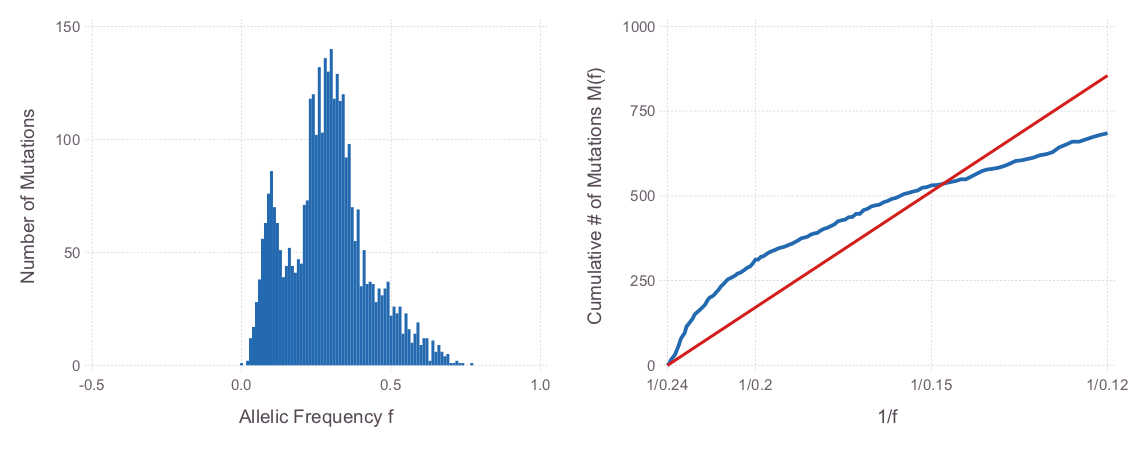

In [40]:
examples = [5,7,9,17,22,25,28,41]

#seed the random number generator with one of the above for some clear examples of VAF histograms influenced by selection
srand(examples[1])
DFhist,DFfit,coefficient,rsq,S=idealsampling_selection(popsize,p,mu,selectiongen,clonalpeak,normalcontamination,min_range,max_range,det_limit,ploidy,read_depth);
set_default_plot_size(30cm, 12cm)

p1=plot(DFhist,x="VAF",y="freq",Geom.bar,Guide.xlabel("Allelic Frequency f"),Guide.ylabel("Number of Mutations"),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
default_color=colormap("blues")[80],bar_spacing=0.00001cm))

p2=plot(DFfit,layer(x="invVAF",y="prediction",Geom.line,Theme(default_color=default_color=colormap("reds")[80],line_width=0.08cm)),
layer(x="invVAF",y="cumsum",Geom.line,Theme(line_width=0.1cm,default_color=colormap("blues")[80])),
Scale.x_continuous(minvalue=minimum(DFfit[:invVAF]), maxvalue=maximum(DFfit[:invVAF]),labels=func),
Scale.y_continuous(minvalue=0, maxvalue=maximum(DFfit[:cumsum])),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm),
#Guide.manual_color_key("", ["Simulated Data", "Model Fit"], [color(colormap("blues")[80]), color(colormap("reds")[80])]),
Guide.xlabel("1/f"),Guide.ylabel("Cumulative # of Mutations M(f)"),
Guide.xticks(ticks=[1/(max_range)-1/max_range,1/0.2-1/max_range,1/0.15-1/max_range,1/0.12-1/max_range]))

println("R^2 = $rsq")
println("population size when fitter mutant introduced = $(S.popsize_event)")
println("number of cells of fitter type = $(S.numU)")


hstack(p1,p2)

In [41]:
sname="selection.$(adv)"

writetable("$(data_dir)/$(today).$(sname).hist.csv",DFhist)
writetable("$(data_dir)/$(today).$(sname).fit.csv",DFfit)
draw(PDF("$(data_dir)/$(today).$(sname).histogram.pdf", 15cm, 12cm), p1)
draw(PDF("$(data_dir)/$(today).$(sname).cumulative.pdf", 15cm, 12cm), p2)

population size when fitter mutant introduced = 65
number of cells of fitter type = 745


# Change in mutation rate

Finally we show that a change in mutation rate also influences the distribution.

In [42]:
normalcontamination = 0
min_range = 0.12
max_range = 0.24

#after a few generations we get a 10fold increase in the mutation rate
mu_old=10
mu_new=100
clonalpeak = 2
det_limit = 0.1
read_depth = 100
popsize = 1000
ploidy = 2

#set selective advantage to 0 as we are only interested in the effect of a change in the mutation rate
adv = 0.0
p=setupprob(adv)
p=prob([0.0,0.0,1.0],[0.0,0.0,1.0])

#generation the phenotype with higher mutation rate introduced mutant is introduced
selectiongen=3


3

R^2 = 0.9652022233880752


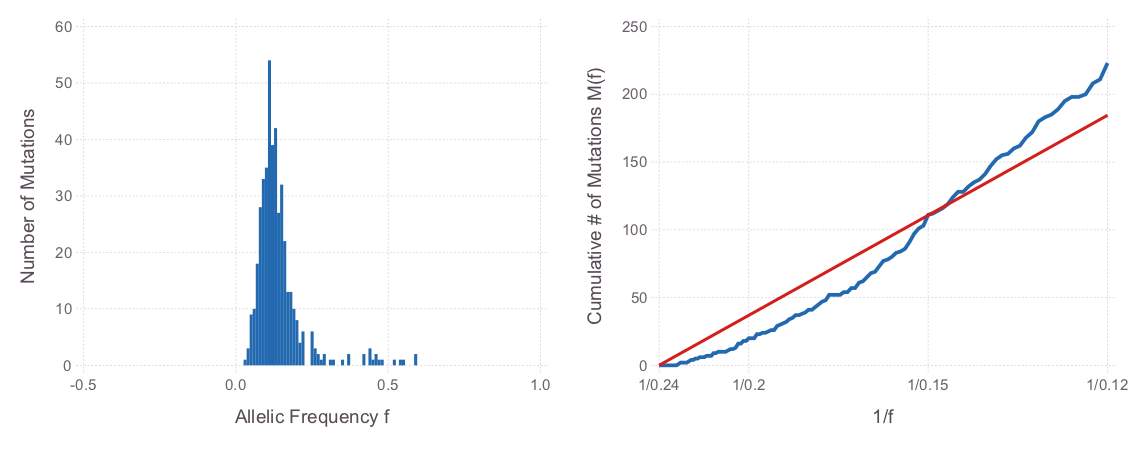

In [43]:
DFhist,DFfit,coefficient,rsq,S=idealsampling_mutation(popsize,p,mu_old,mu_new,selectiongen,clonalpeak,normalcontamination,min_range,max_range,det_limit,ploidy,read_depth);
set_default_plot_size(30cm, 12cm)

p1=plot(DFhist,x="VAF",y="freq",Geom.bar,Guide.xlabel("Allelic Frequency f"),Guide.ylabel("Number of Mutations"),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
default_color=colormap("blues")[80],bar_spacing=0.00001cm))

p2=plot(DFfit,layer(x="invVAF",y="prediction",Geom.line,Theme(default_color=default_color=colormap("reds")[80],line_width=0.08cm)),
layer(x="invVAF",y="cumsum",Geom.line,Theme(line_width=0.1cm,default_color=colormap("blues")[80])),
Scale.x_continuous(minvalue=minimum(DFfit[:invVAF]), maxvalue=maximum(DFfit[:invVAF]),labels=func),
Scale.y_continuous(minvalue=0, maxvalue=maximum(DFfit[:cumsum])),
Theme(major_label_font_size=0.5cm,major_label_font="Arial",minor_label_font_size=0.4cm,minor_label_font="Arial",
key_label_font="Arial",key_label_font_size=0.4cm),
#Guide.manual_color_key("", ["Simulated Data", "Model Fit"], [color(colormap("blues")[80]), color(colormap("reds")[80])]),
Guide.xlabel("1/f"),Guide.ylabel("Cumulative # of Mutations M(f)"),
Guide.xticks(ticks=[1/(max_range)-1/max_range,1/0.2-1/max_range,1/0.15-1/max_range,1/0.12-1/max_range]))

println("R^2 = $rsq")
println("population size when higher mutation rate phenotype introduced = $(S.popsize_event)")

hstack(p1,p2)

In [44]:
sname="change_mu"

writetable("$(data_dir)/$(today).$(sname).hist.csv",DFhist)
writetable("$(data_dir)/$(today).$(sname).fit.csv",DFfit)
draw(PDF("$(data_dir)/$(today).$(sname).histogram.pdf", 15cm, 12cm), p1)
draw(PDF("$(data_dir)/$(today).$(sname).cumulative.pdf", 15cm, 12cm), p2)

population size when higher mutation rate phenotype introduced = 4
